<a href="https://colab.research.google.com/github/rahaveep/OPTIMIZERS-FOR-EVALUATION---COMPUTER-VISION/blob/main/CIFAR_10_in_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Introduction to Deep Learning with Keras and TensorFlow

**Daniel Moser (UT Southwestern Medical Center)**

**Resources: [Xavier Snelgrove](https://github.com/wxs/keras-mnist-tutorial), [Yash Katariya](https://github.com/yashk2810/MNIST-Keras)**

To help you understand the fundamentals of deep learning, this demo will walk through the basic steps of building two toy models for classifying handwritten numbers with accuracies surpassing 95%. The first model will be a basic fully-connected neural network, and the second model will be a deeper network that introduces the concepts of convolution and pooling.

## The Task for the AI

Our goal is to construct and train an artificial neural network on thousands of images of handwritten digits so that it may successfully identify others when presented. The data that will be incorporated is the MNIST database which contains 60,000 images for training and 10,000 test images. We will use the Keras Python API with TensorFlow as the backend.

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [ ]:
import numpy as np # advanced math library 
import matplotlib.pyplot as plt # MATLAB like plotting routines 
import random # for generating random numbers 
import keras
import time 
from keras.datasets import cifar10 # MNIST dataset is included in Keras 
from keras.models import Sequential # Model type to be used
from keras.models import Sequential

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model 
from keras.utils import np_utils # NumPy related tools

In [ ]:
opt= 'RMSprop'

import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers
import keras
from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

## Loading Training Data

The MNIST dataset is conveniently bundled within Keras, and we can easily analyze some of its features in Python.

In [ ]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
#(X_trainMNIST, y_trainMNIST), (X_testMNIST, y_testMNIST) = mnist.load_data()
#X, y = np.load("sub6_data.npy"), np.load('label_data.npy')
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=33)
#print("X_train shape", X_train.shape)
#print("y_train shape", y_train.shape)
#print("X_test shape", X_test.shape)
#print("y_test shape", y_test.shape)
#print(y_test)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


Using matplotlib, we can plot some sample images from the training set directly into this Jupyter Notebook.

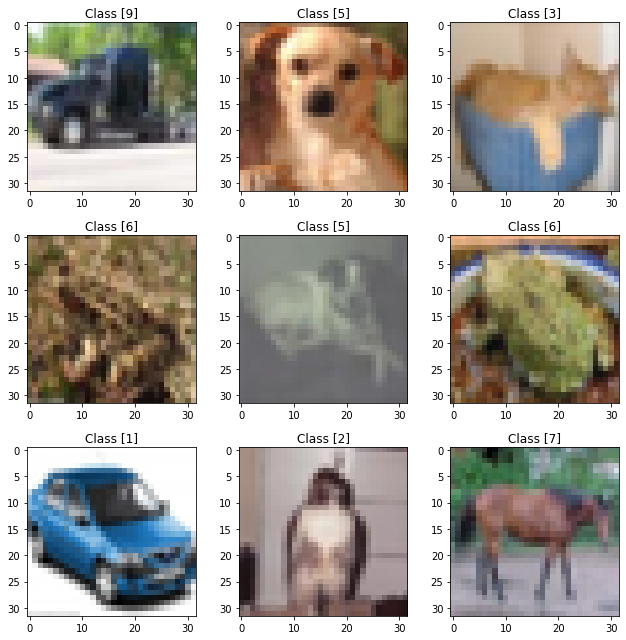

In [ ]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(x_test))
    plt.imshow(x_test[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_test[num]))
    
plt.tight_layout()

Let's examine a single digit a little closer, and print out the array representing the last digit.

In [ ]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!        

Each pixel is an 8-bit integer from 0-255. 0 is full black, while 255 is full white. This what we call a single-channel pixel. It's called monochrome.

*Fun-fact! Your computer screen has three channels for each pixel: red, green, blue. Each of these channels also likely takes an 8-bit integer. 3 channels -- 24 bits total -- 16,777,216 possible colors!*

## Formatting the input data layer

Instead of a 28 x 28 matrix, we build our network to accept a 784-length vector.

Each image needs to be then reshaped (or flattened) into a vector. We'll also normalize the inputs to be in the range [0-1] rather than [0-255]. Normalizing inputs is generally recommended, so that any additional dimensions (for other network architectures) are of the same scale.

<img src='https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/flatten.png?raw=1' >

In [ ]:

X_train = x_train.reshape(50000, 3072) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = x_test.reshape(10000, 3072)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)


Training matrix shape (50000, 3072)
Testing matrix shape (10000, 3072)


We then modify our classes (unique digits) to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
then it is most probable that the image is that of the digit `1`.

In [ ]:
nb_classes = 10 # number of unique digits
from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)
print(Y_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


# Building a 3-layer fully connected network (FCN)

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/figure.png?raw=1" />

In [ ]:
# The Sequential model is a linear stack of layers and is very common.

model = Sequential()

## The first hidden layer

In [ ]:

# The first hidden layer is a set of 512 nodes (artificial neurons).
# Each node will receive an element from each input vector and apply some weight and bias to it.

model.add(Dense(512, input_shape=(3072,))) #(784,) is not a typo -- that represents a 784 length vector!

In [ ]:
# An "activation" is a non-linear function applied to the output of the layer above.
# It checks the new value of the node, and decides whether that artifical neuron has fired.
# The Rectified Linear Unit (ReLU) converts all negative inputs to nodes in the next layer to be zero.
# Those inputs are then not considered to be fired.
# Positive values of a node are unchanged.

model.add(Activation('relu'))   #other option relu




$$f(x) = max (0,x)$$
<img src = 'relu.jpg' >

In [ ]:


# Dropout zeroes a selection of random outputs (i.e., disables their activation)
# Dropout helps protect the model from memorizing or "overfitting" the training data.
model.add(Dropout(0.5))





## Adding the second hidden layer

In [ ]:
# The second hidden layer appears identical to our first layer.
# However, instead of each of the 512-node receiving 784-inputs from the input image data,
# they receive 512 inputs from the output of the first 512-node layer.

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))


## The Final Output Layer

In [ ]:



# The final layer of 10 neurons in fully-connected to the previous 512-node layer.
# The final layer of a FCN should be equal to the number of desired classes (10 in this case).
model.add(Dense(10))

In [ ]:



# The "softmax" activation represents a probability distribution over K different possible outcomes.
# Its values are all non-negative and sum to 1.

model.add(Activation('softmax'))

In [ ]:
# Summarize the built model

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 512)               1573376   
_________________________________________________________________
activation_39 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_40 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 10)              

## Compiling the model

Keras is built on top of Theano and TensorFlow. Both packages allow you to define a *computation graph* in Python, which then compiles and runs efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called *categorical cross-entropy*, and is a loss function well-suited to comparing two probability distributions.

Our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

The optimizer helps determine how quickly the model learns through **gradient descent**. The rate at which descends a gradient is called the **learning rate**.

<img src = "gradient_descent.png" >

<img src = "learning_rate.png" >

So are smaller learning rates better? Not quite! It's important for an optimizer not to get stuck in local minima while neglecting the global minimum of the loss function. Sometimes that means trying a larger learning rate to jump out of a local minimum.

<img src = 'complicated_loss_function.png' >

In [ ]:

# Let's use the Adam optimizer for learning
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:



import time
starttime=time.time()
history = model.fit(X_train, Y_train,
          batch_size=125, epochs=50,#128 to 60000
                            verbose=2,
                            callbacks = [keras.callbacks.ModelCheckpoint( './', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')])

endtime=time.time()
time=endtime-starttime
print (time)

Epoch 1/50
400/400 - 2s - loss: 2.1963 - accuracy: 0.1956
Epoch 2/50
400/400 - 1s - loss: 2.0155 - accuracy: 0.2487
Epoch 3/50
400/400 - 1s - loss: 1.9687 - accuracy: 0.2744
Epoch 4/50
400/400 - 1s - loss: 1.9422 - accuracy: 0.2847
Epoch 5/50
400/400 - 1s - loss: 1.9184 - accuracy: 0.2977
Epoch 6/50
400/400 - 1s - loss: 1.9029 - accuracy: 0.3008
Epoch 7/50
400/400 - 1s - loss: 1.8886 - accuracy: 0.3059
Epoch 8/50
400/400 - 1s - loss: 1.8821 - accuracy: 0.3108
Epoch 9/50
400/400 - 1s - loss: 1.8692 - accuracy: 0.3172
Epoch 10/50
400/400 - 1s - loss: 1.8588 - accuracy: 0.3202
Epoch 11/50
400/400 - 1s - loss: 1.8554 - accuracy: 0.3245
Epoch 12/50
400/400 - 1s - loss: 1.8487 - accuracy: 0.3235
Epoch 13/50
400/400 - 1s - loss: 1.8442 - accuracy: 0.3298
Epoch 14/50
400/400 - 1s - loss: 1.8441 - accuracy: 0.3293
Epoch 15/50
400/400 - 1s - loss: 1.8391 - accuracy: 0.3301
Epoch 16/50
400/400 - 1s - loss: 1.8353 - accuracy: 0.3330
Epoch 17/50
400/400 - 1s - loss: 1.8294 - accuracy: 0.3321
Epoch 

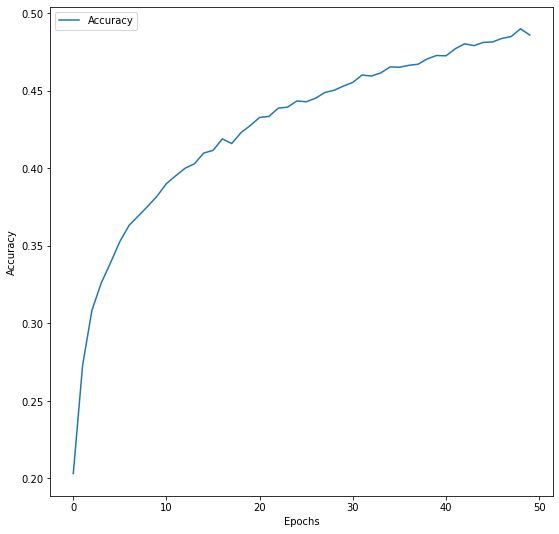

In [ ]:
#plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('model_training_history')
plt.show()

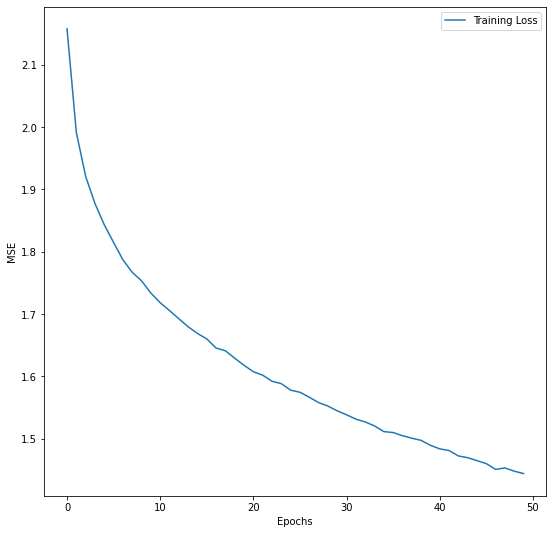

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
#plt.plot(history.history['accuracy'], label='Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.savefig('model_training_history')
plt.show()

## Train the model!
This is the fun part! 

The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation. Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum.

Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum.

So a good batch size may take some trial and error to find!

In [ ]:

model.fit(X_train, Y_train,
          batch_size=125, epochs=5,#128 to 60000
          verbose=1)

Epoch 1/5
400/400 [==============================] - 2s 4ms/step - loss: 1.4409 - accuracy: 0.4890
Epoch 2/5
400/400 [==============================] - 2s 5ms/step - loss: 1.4318 - accuracy: 0.4920
Epoch 3/5
400/400 [==============================] - 2s 5ms/step - loss: 1.4345 - accuracy: 0.4922
Epoch 4/5
400/400 [==============================] - 2s 5ms/step - loss: 1.4246 - accuracy: 0.4938
Epoch 5/5
400/400 [==============================] - 2s 5ms/step - loss: 1.4279 - accuracy: 0.4917


The two numbers, in order, represent the value of the loss function of the network on the training set, and the overall accuracy of the network on the training data. But how does it do on data it did not train on?

## Evaluate Model's Accuracy on Test Data

In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 4ms/step - loss: 1.7847 - accuracy: 0.3943
Test score: 1.7846921682357788
Test accuracy: 0.39430001378059387


### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [ ]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = np.argmax(model.predict(X_test),axis=1)#model.predict(X_test)
#print(Y_test)
new_Y_test = np.argmax(Y_test,axis=1)
print(predicted_classes)
print(new_Y_test)
# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
#print(correct_indices)
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

[3 0 0 2 1 2 2 2 1 2 3 0 3 1 0 2 3 3 3 2 0 3 0 3 3 0 1 1 2 2 3 1 2 0 0 3 1
 2 3 2 2 1 0 2 1 1 1 3 1 2 2 0 3 2 3 3 0 1 1 3 2 1 1 0 0 2 2 0 1 0 1 0 2 3
 3 2 0 1 3 0 0 3 1 1 3 2 1 3 1 0 2 2 0 0 2 0 3 0 0 3 2 2 1 0 3 2 2 3 3 3 1
 1 1 0 1 2 0 0 1 0 1 1 0 3 0 3 0 3 1 1 3 3 1 3 2 1 1 2 0 2 1 2 0 3 0 0 0 0
 1 3 0 3 1 1 2 3 3 0 0 2 2 3 0 3 3 1 3 0 3 1 2 2 2 3 1 3 0 1 1 0 0 3 1 0 2
 3 0 2 2 0 1 3 3 3 0 0 3 2 2 0 0 2 3 2 3 1 1 1 3 3 1 0 2 2 2 0 3 2 3 3 1 3
 1 3 3 2 1 1 2 1 0 0 0 2 3 2 3 3 2 2 1 3 3 1 0 0 2 3 2 0 0 2 0 3 2 0 0 3 1
 2 1 0 1 0 2 1 3 3 2 2 3 1 2 1 1 2 1 0 2 2 3 3 0 0 3 3 0 0 1 3 3 2 3 0 0 1
 2 1 0 1 3 1 2 1 1 0 0 3 3 3 3 2 3 0 0 1 0 3 3 0 3 2 2 3 0 2 0 2 0 3 3 1 0
 0 3 1 1 3 1 0 0 2 0 1 1 1 0 3 2 0 0 0 2 0 0 3 3 0 2 0 2 2 2 3 0 0 2 3 0 1
 3 2 2 2 1 0 1 2 1 1 2 0 0 1 0 3 0 0 0 3 3 3 0 0 2 0 1 2 3 2 2 2 2 1 2 2 2
 2 0 1 2 3 0 2 1 1 0 1 2 3 0 3 2 1 1 0 0 1 0 3 1 0 3 3 0 2 0 1 0 0 3 1 3 1
 2 2 2 1 2 0 3 3 3 1 0 0 0 3 1 3 3 3 3 0 3 0 0 1 0 2 0 2 2 1 0 1 2 0 2 2 1
 1 1 2 3 1 3 3 1 3 0 1 0 

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
cm=tf.math.confusion_matrix(new_Y_test,predicted_classes)
import seaborn as sns
# Make predictions
#y_pred = model.predict(X_test)

# Build confusion metrics
#cm = confusion_matrix(y_true=Y_test, y_pred=predicted_classes)
#print(cm)

# Plot confusion matrix in a beautiful manner
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('top') 
#ax.xaxis.set_ticklabels(['ham', 'spam'], fontsize = 15)
ax.xaxis.tick_top()

ax.set_ylabel('True', fontsize=20)
#ax.yaxis.set_ticklabels(['spam', 'ham'], fontsize = 15)
plt.show()



NameError: ignored

In [ ]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.tight_layout()
    
plt.figure(figsize=(10,10))
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    
plt.tight_layout()

# Trying experimenting with the batch size!

#### How does increasing the batch size to 10,000 affect the training time and test accuracy?

#### How about a batch size of 32?

# Introducing Convolution! What is it?

Before, we built a network that accepts the normalized pixel values of each value and operates soley on those values. What if we could instead feed different features (e.g. **curvature, edges**) of each image into a network, and have the network learn which features are important for classifying an image?

This possible through convolution! Convolution applies **kernels** (filters) that traverse through each image and generate **feature maps**.

<img src = 'convolution.gif' >

In the above example, the image is a 5 x 5 matrix and the kernel going over it is a 3 x 3 matrix. A dot product operation takes place between the image and the kernel and the convolved feature is generated. Each kernel in a CNN learns a different characteristic of an image.

Kernels are often used in photoediting software to apply blurring, edge detection, sharpening, etc.

<img src = 'kernels.png' >

Kernels in deep learning networks are used in similar ways, i.e. highlighting some feature. Combined with a system called **max pooling**, the non-highlighted elements are discarded from each feature map, leaving only the features of interest, reducing the number of learned parameters, and decreasing the computational cost (e.g. system memory).

<img src = 'max_pooling.png' >

We can also take convolutions of convolutions -- we can stack as many convolutions as we want, as long as there are enough pixels to fit a kernel.

*Warning: What you may find down there in those deep convolutions may not appear recognizable to you.*

<img src = 'go_deeper.jpg' >

## Building a "Deep" Convolutional Neural Network

In [ ]:
# import some additional tools

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers.normalization import BatchNormalization

In [ ]:
# Reload the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
# Again, do some formatting
# Except we do not flatten each image into a 784-length vector because we want to perform convolutions first

X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

In [ ]:
# one-hot format classes

nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [ ]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1))) # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer01 = Activation('relu')                     # activation
model.add(convLayer01)

# Convolution Layer 2
model.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer02)

# Convolution Layer 3
model.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer03 = Activation('relu')                     # activation
model.add(convLayer03)

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer04)
model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

# Fully Connected Layer 5
model.add(Dense(512))                                # 512 FCN nodes
model.add(BatchNormalization())                      # normalization
model.add(Activation('relu'))                        # activation

# Fully Connected Layer 6                       
model.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
model.add(Dense(10))                                 # final 10 FCN nodes
model.add(Activation('softmax'))                     # softmax activation

In [ ]:
model.summary()

In [ ]:
# we'll use the same optimizer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# data augmentation prevents overfitting by slightly changing the data randomly
# Keras has a great built-in feature to do automatic augmentation

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [ ]:
# We can then feed our augmented data in batches
# Besides loss function considerations as before, this method actually results in significant memory savings
# because we are actually LOADING the data into the network in batches before processing each batch

# Before the data was all loaded into memory, but then processed in batches.

train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [ ]:
# We can now train our model which is fed data by our batch loader
# Steps per epoch should always be total size of the set divided by the batch size

# SIGNIFICANT MEMORY SAVINGS (important for larger, deeper networks)

model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1, 
                    validation_data=test_generator, validation_steps=10000//128)

In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

## Great results! 

But wouldn't it be nice if we could visualize those convolutions so that we can see what the model is seeing?

In [ ]:
from keras import backend as K

# choose any image to want by specifying the index
img = X_test[3]
img = np.expand_dims(img, axis=0) # Keras requires the image to be in 4D, so we add an extra dimension to it.

# Not important to understand how this function work -- It just plots a convolution layer

def visualize(layer):
    inputs = [K.learning_phase()] + model.inputs
    
    _convout1_f = K.function(inputs, [layer.output])
    
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    m = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(m)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(15,12))
    for i in range(m):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[:,:,i], cmap='gray')


In [ ]:
plt.figure()
plt.imshow(X_test[3].reshape(28,28), cmap='gray', interpolation='none')

In [ ]:
visualize(convLayer01) # visualize first set of feature maps

In [ ]:
visualize(convLayer02) # visualize second set of feature maps

In [ ]:
visualize(convLayer03)# visualize third set of feature maps

In [ ]:
visualize(convLayer04)# visualize fourth set of feature maps

#### For a 3D visualization of a very similar network, visit http://scs.ryerson.ca/~aharley/vis/conv/

In [ ]:
a=1
